In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf
from bayesflow.diagnostics.plot_losses import plot_losses
from bayesflow.diagnostics.plot_recovery import plot_recovery

In [2]:
def alpha_prior():
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    return dict(alpha=alpha)

def r_prior():
    r = np.random.normal(0.1, 0.01)
    return dict(r=r)

def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta, alpha, r):
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

In [3]:
simulator = bf.simulators.CompositeLambdaSimulator([alpha_prior, r_prior, theta_prior, forward_model])

In [4]:
# generate 128 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample((128,))

In [5]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['alpha', 'r', 'theta', 'x'])
Types of sample_data values:
	 {'alpha': <class 'numpy.ndarray'>, 'r': <class 'numpy.ndarray'>, 'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'alpha': (128, 1), 'r': (128, 1), 'theta': (128, 2), 'x': (128, 2)}


In [6]:
sample_data

{'alpha': array([[-0.32667086],
        [ 0.4273289 ],
        [-1.4049091 ],
        [ 0.6495664 ],
        [-1.2431567 ],
        [ 0.00233715],
        [ 0.8480671 ],
        [ 0.3825317 ],
        [ 0.51094717],
        [-1.089614  ],
        [-1.3354424 ],
        [ 1.521167  ],
        [-0.39602077],
        [ 0.88564837],
        [ 0.9123921 ],
        [-0.8354839 ],
        [ 0.4103786 ],
        [-1.3677335 ],
        [ 1.5597553 ],
        [ 0.857706  ],
        [ 1.3851596 ],
        [ 0.08588123],
        [-1.3278203 ],
        [-1.4882586 ],
        [-0.7284002 ],
        [ 0.13790596],
        [ 1.0051142 ],
        [-1.2707354 ],
        [-1.4755409 ],
        [-0.03580285],
        [-1.5595189 ],
        [-0.67198914],
        [-1.5414019 ],
        [ 0.46680772],
        [-0.49131817],
        [ 1.3081697 ],
        [ 1.3158842 ],
        [ 0.5498999 ],
        [ 0.28842863],
        [ 1.5669599 ],
        [ 1.1178267 ],
        [-1.3773671 ],
        [ 0.21009572],
  

In [57]:
# data_adapter = configurator
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["theta"],
    inference_conditions=["x"],
)

In [8]:
num_training_batches = 1024
num_validation_batches = 256
batch_size = 128

In [9]:
training_samples = simulator.sample((num_training_batches * batch_size,))
validation_samples = simulator.sample((num_validation_batches * batch_size,))

In [10]:
training_dataset = bf.datasets.OfflineDataset(training_samples, batch_size=batch_size, data_adapter=data_adapter)
validation_dataset = bf.datasets.OfflineDataset(validation_samples, batch_size=batch_size, data_adapter=data_adapter)

In [11]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)

In [12]:
# Approximator is equivalent to Amortizer
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

In [13]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [14]:
class BatchLossHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        # 'logs' is a dictionary containing loss and other metrics
        loss = logs.get('loss')
        self.batch_losses.append(loss)

In [15]:
approximator.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy"
)

In [16]:
batch_loss_history = BatchLossHistory()

In [17]:
history = approximator.fit(
    epochs=30,
    dataset=training_dataset,
    validation_data=validation_dataset,
    callbacks=[batch_loss_history]
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.6919 - loss/inference_loss: 0.6919 - val_loss: 0.6134 - val_loss/inference_loss: 0.6134
Epoch 2/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.6234 - loss/inference_loss: 0.6234 - val_loss: 0.6321 - val_loss/inference_loss: 0.6321
Epoch 3/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.6018 - loss/inference_loss: 0.6018 - val_loss: 0.4567 - val_loss/inference_loss: 0.4567
Epoch 4/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.6079 - loss/inference_loss: 0.6079 - val_loss: 0.6692 - val_loss/inference_loss: 0.6692
Epoch 5/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.5956 - loss/inference_loss: 0.5956 - val_loss: 0.7312 - val_loss/inference_loss: 0.7312
Epoch 6/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.5911 - loss/inference_loss: 0.5911 - val_loss: 0.5461 - val_loss/inference_loss: 0.5461
Epoch 7/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.5907 - los

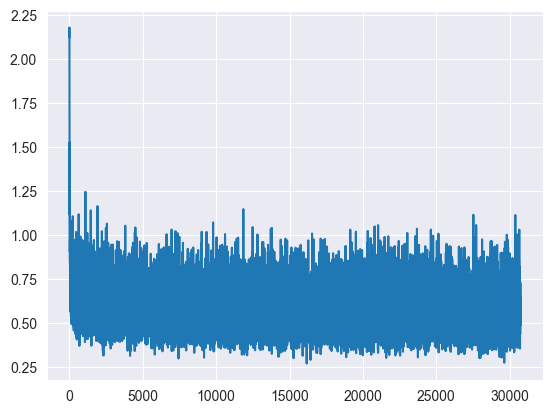

In [18]:
plt.plot(batch_loss_history.batch_losses)

# Validation

In [55]:
# Set the number of posterior draws you want to get
num_samples = 500

# Obtain samples from amortized posterior
conditions = {"x": np.array([[0.0, 0.0]]).astype("float32")}
samples_at_origin = approximator.sample(conditions=conditions, num_samples=num_samples)

In [56]:
samples_at_origin

{'theta': array([[[ 0.17654721,  0.27041006],
         [ 0.12645097,  0.24587561],
         [-0.19934806, -0.278135  ],
         [-0.24838944, -0.24566503],
         [-0.23984583, -0.25675145],
         [ 0.15274203,  0.27565002],
         [-0.17649002, -0.28321353],
         [ 0.2847274 ,  0.16072123],
         [ 0.26681536,  0.14605851],
         [ 0.17062895,  0.26429826],
         [-0.28589755, -0.17278582],
         [-0.18308169, -0.29656368],
         [ 0.23003347,  0.24603625],
         [ 0.24050273,  0.21084891],
         [ 0.26269466,  0.12824804],
         [ 0.1484585 ,  0.26595044],
         [ 0.26594985,  0.2410507 ],
         [ 0.25229037,  0.24877094],
         [-0.21716174, -0.25466734],
         [ 0.22001   ,  0.258107  ],
         [-0.26463276, -0.12307405],
         [ 0.25718766,  0.23288907],
         [-0.23486198, -0.09413613],
         [ 0.27260107,  0.22248606],
         [-0.24408428, -0.2348922 ],
         [ 0.28494632,  0.16640714],
         [-0.23431693, -0.249

In [42]:
sample_data["theta"].shape

(128, 2)

In [50]:
np.reshape(samples_at_origin, (128, 2, 1)).shape

(128, 2, 1)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

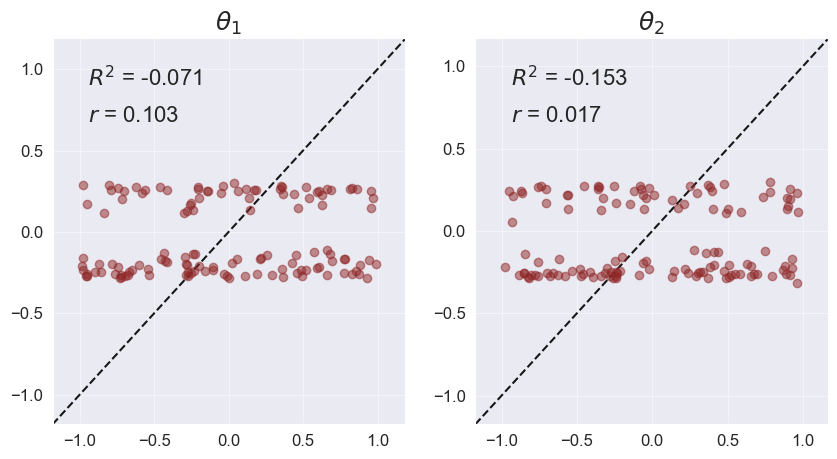

In [53]:
f = plot_recovery(post_samples=np.swapaxes(samples_at_origin, 0, 1), prior_samples=np.array(sample_data['theta']))